In [1]:
import nltk
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from heapq import nlargest
from collections import Counter
from nltk.corpus import stopwords
from rouge_score import rouge_scorer
from nltk import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('punkt')

D:\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yoga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv('news_summarization.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'ID', 'Content', 'Summary', 'Dataset'], dtype='object')

In [4]:
df.drop(["Unnamed: 0", "ID", "Dataset"], axis=1, inplace=True)

In [5]:
df.columns

Index(['Content', 'Summary'], dtype='object')

## <center>Data Cleaning</center>

In [6]:
def remove_stopwords(text):
    if pd.notna(text):
        # Tokenize the text into words
        words = text.split()

        # Remove stop words
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

        # Join the words back into cleaned text
        cleaned_text = ' '.join(words)

        return cleaned_text
    
    else:
        return text

In [7]:
df['Content'] = df['Content'].apply(remove_stopwords)
df['Summary'] = df['Summary'].apply(remove_stopwords)

In [8]:
nan_rows = df[df['Content'].isna()]
print(nan_rows)

       Content                                            Summary
10839      NaN     Images courtesy AFP, EPA, Getty Images Reuters
14701      NaN  President Barack Obama arrived Cuba historic v...
45600      NaN  Our selection best news photographs taken arou...
89037      NaN  Here full list winners nominees 2017 Bafta TV ...
99783      NaN                       All photographs copyrighted.
118847     NaN  Following news Birmingham City Council's child...
142166     NaN  Our selection best news photographs taken arou...
158232     NaN             A selection photos across Africa week:
189368     NaN  Lebanon placed new restrictions Syrians enteri...
194150     NaN                 All photographs subject copyright.
267224     NaN  Nigeria's commercial capital, Lagos, makeover ...
269158     NaN  A selection photos across African continent week:
283567     NaN  Our selection best news photographs taken arou...
285807     NaN                All photographs © Press Association
292472    

In [9]:
df = df.dropna(subset=['Content'])

In [10]:
nan_rows = df[df['Content'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [Content, Summary]
Index: []


## <center>Split Dataset</center>

In [8]:
train_percentage = 0.7 
test_percentage = 0.15
validation_percentage = 0.15

train_df, temp_df = train_test_split(df, test_size = 1 - train_percentage, random_state = 42)

test_df, val_df = train_test_split(temp_df, test_size = validation_percentage / (validation_percentage + test_percentage), random_state = 42)

## <center>Techniques</center>

### Luhn Method

In [39]:
def luhn_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)
    
    # Tokenize the entire article into words
    words = word_tokenize(article)
    
    # Calculate word frequencies using Counter
    word_frequencies = Counter(words)

    # Initialize a dictionary to store sentence scores
    sentence_scores = {}

    # Calculate scores for each sentence
    for sentence in sentences:
        # Tokenize the sentence into words and convert to lowercase
        for word in word_tokenize(sentence.lower()):
            # Check if the word is in the word frequencies
            if word in word_frequencies:
                # If the sentence is not in the scores dictionary, initialize it
                if sentence not in sentence_scores:
                    sentence_scores[sentence] = word_frequencies[word]
                else:
                    # If the sentence is already in the dictionary, add the word's frequency
                    sentence_scores[sentence] += word_frequencies[word]

    # Get the top 'num_sentences' sentences with the highest scores
    summary_sentences = nlargest(num_sentences, sentence_scores, key=sentence_scores.get)

    # Combine the selected sentences to create the summary
    summary = ' '.join(summary_sentences)
    
    return summary

In [40]:
# Apply Luhn Method to each article in the training dataset and store summaries
train_df['luhn_summary'] = train_df['Content'].apply(lambda x: luhn_summarize(x, num_sentences=3))

# Apply Luhn Method to each article in the testing dataset and store summaries
test_df['luhn_summary'] = test_df['Content'].apply(lambda x: luhn_summarize(x, num_sentences=3))

# Apply Luhn Method to each article in the validation dataset and store summaries
val_df['luhn_summary'] = val_df['Content'].apply(lambda x: luhn_summarize(x, num_sentences=3))

In [ ]:
# Save the results to new CSV files for each dataset
train_df.to_csv("cnn_train_with_luhn_summaries.csv", index=False)
test_df.to_csv("cnn_test_with_luhn_summaries.csv", index=False)
val_df.to_csv("cnn_val_with_luhn_summaries.csv", index=False)

In [46]:
# Define a function to calculate ROUGE scores
def calculate_rouge_scores(df):
    # Initialize the ROUGE scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lists to store the ROUGE scores
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for _, row in df.iterrows():
        reference_summary = row['Summary']
        luhn_summary = row['luhn_summary']

        # Check if reference_summary or luhn_summary is None or empty
        if reference_summary is None or luhn_summary is None or reference_summary == "" or luhn_summary == "":
            # Append 0.0 for precision, recall, and fmeasure
            rouge1_scores.append([{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}])
            rouge2_scores.append([{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}])
            rougeL_scores.append([{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}])
            
        else:
            # Calculate ROUGE scores
            scores = rouge.score(luhn_summary, reference_summary)

            rouge1_scores.append([{
                'precision': round(scores['rouge1'].precision, 2),
                'recall': round(scores['rouge1'].recall, 2),
                'fmeasure': round(scores['rouge1'].fmeasure, 2)
            }])
            
            rouge2_scores.append([{
                'precision': round(scores['rouge2'].precision, 2),
                'recall': round(scores['rouge2'].recall, 2),
                'fmeasure': round(scores['rouge2'].fmeasure, 2)
            }])
            
            rougeL_scores.append([{
                'precision': round(scores['rougeL'].precision, 2),
                'recall': round(scores['rougeL'].recall, 2),
                'fmeasure': round(scores['rougeL'].fmeasure, 2)
            }])

    df['rouge1'] = rouge1_scores
    df['rouge2'] = rouge2_scores
    df['rougeL'] = rougeL_scores
    
    # Print the ROUGE scores for the first row for debugging
    print("Rouge1 Scores:", rouge1_scores[0])
    print("Rouge2 Scores:", rouge2_scores[0])
    print("RougeL Scores:", rougeL_scores[0])

In [47]:
# Calculate ROUGE scores for train dataset
calculate_rouge_scores(train_df)

Rouge1 Scores: [{'precision': 0.21, 'recall': 0.09, 'fmeasure': 0.13}]
Rouge2 Scores: [{'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0}]
RougeL Scores: [{'precision': 0.17, 'recall': 0.07, 'fmeasure': 0.1}]


In [48]:
# Calculate ROUGE scores for test dataset
calculate_rouge_scores(test_df)

Rouge1 Scores: [{'precision': 0.2, 'recall': 0.11, 'fmeasure': 0.15}]
Rouge2 Scores: [{'precision': 0.03, 'recall': 0.02, 'fmeasure': 0.02}]
RougeL Scores: [{'precision': 0.17, 'recall': 0.1, 'fmeasure': 0.12}]


In [49]:
# Calculate ROUGE scores for validation dataset
calculate_rouge_scores(val_df)

Rouge1 Scores: [{'precision': 0.42, 'recall': 0.11, 'fmeasure': 0.17}]
Rouge2 Scores: [{'precision': 0.09, 'recall': 0.02, 'fmeasure': 0.04}]
RougeL Scores: [{'precision': 0.33, 'recall': 0.09, 'fmeasure': 0.14}]


In [ ]:
# Save the train dataset with ROUGE scores
train_df.to_csv("cnn_test_with_rouge_scores.csv", index=False)

# Save the test dataset with ROUGE scores
test_df.to_csv("cnn_test_with_rouge_scores.csv", index=False)

# Save the validation dataset with ROUGE scores
val_df.to_csv("cnn_val_with_rouge_scores.csv", index=False)

### TextRank

In [60]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

def textrank_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)

    # Vectorize sentences using CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(sentences)
    vectors = X.toarray()

    # Calculate cosine similarity between sentence vectors
    similarity_matrix = cosine_similarity(vectors, vectors)

    # Create a graph representation of sentences
    sentence_graph = nx.Graph()
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                sentence_graph.add_edge(i, j, weight=similarity_matrix[i][j])

    # Calculate TextRank scores
    scores = nx.pagerank(sentence_graph)

    # Sort sentences by their TextRank scores
    ranked_sentences = sorted(((scores[i], sentence) for i, sentence in enumerate(sentences)), reverse=True)

    # Get the top 'num_sentences' sentences for the summary
    summary_sentences = [sentence for score, sentence in ranked_sentences[:num_sentences]]

    # Combine selected sentences into the summary
    summary = ' '.join(summary_sentences)
    return summary

In [ ]:
# Apply TextRank summarization to the train dataset
train_df['textrank_summary'] = train_df['Content'].apply(lambda x: textrank_summarize(x, num_sentences=3))

# Apply TextRank summarization to the test dataset
test_df['textrank_summary'] = test_df['Content'].apply(lambda x: textrank_summarize(x, num_sentences=3))

# Apply TextRank summarization to the validation dataset
val_df['textrank_summary'] = val_df['Content'].apply(lambda x: textrank_summarize(x, num_sentences=3))

### LexRank

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
from heapq import nlargest
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

def lexrank_summarize(article, num_sentences):
    # Tokenize the article into sentences
    sentences = sent_tokenize(article)
    
    # Vectorize the sentences using TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

    # Calculate similarity matrix using cosine similarity
    sentence_similarity_matrix = cosine_similarity(tfidf_matrix)

    # Apply LexRank
    lx = LexRank(sentences, stopwords=STOPWORDS['en'])
    summary = lx.get_summary(article, summary_size=num_sentences)

    # Combine the selected sentences to create the summary
    summary = ' '.join(summary)
    
    return summary

In [ ]:
# Apply LexRank to each article in the training dataset and store summaries
train_df['lexrank_summary'] = train_df['Content'].apply(lambda x: lexrank_summarize(x, num_sentences=3))

# Apply LexRank to each article in the testing dataset and store summaries
test_df['lexrank_summary'] = test_df['Content'].apply(lambda x: lexrank_summarize(x, num_sentences=3))

# Apply LexRank to each article in the validation dataset and store summaries
val_df['lexrank_summary'] = val_df['Content'].apply(lambda x: lexrank_summarize(x, num_sentences=3))

### Latent Semantic Analysis

In [14]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the article and highlights text
tfidf_matrix_content = tfidf_vectorizer.fit_transform(df['Content'])
tfidf_matrix_summary = tfidf_vectorizer.fit_transform(df['Summary'])

In [16]:
# Define the number of components (latent factors)
n_components = 100  

# Perform Truncated SVD on the TF-IDF matrices
lsa_article = TruncatedSVD(n_components)
lsa_highlights = TruncatedSVD(n_components)

lsa_matrix_content = lsa_article.fit_transform(tfidf_matrix_content)
lsa_matrix_summary = lsa_highlights.fit_transform(tfidf_matrix_summary)

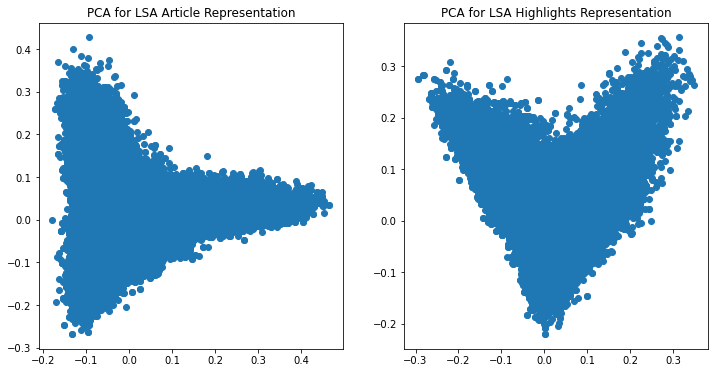

In [20]:
# Perform PCA on the LSA representations
pca_content = PCA(n_components=2)
pca_summary = PCA(n_components=2)

pca_matrix_content = pca_content.fit_transform(lsa_matrix_content)
pca_matrix_summary = pca_summary.fit_transform(lsa_matrix_summary)

# Plot the PCA results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_matrix_content[:, 0], pca_matrix_content[:, 1])
plt.title('PCA for LSA Article Representation')

plt.subplot(1, 2, 2)
plt.scatter(pca_matrix_summary[:, 0], pca_matrix_summary[:, 1])
plt.title('PCA for LSA Highlights Representation')

plt.show()

### LsaSummarizer (Latent Semantic Analysis)